In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [6]:
%%file ../scripts/pull_additional_chip_data.py
"""Pull additional data from Microsoft's Planetary computer"""

import numpy as np
import pandas as pd
import skimage.transform as st

import rioxarray
import rasterio
import rioxarray

import sys
import os
import time
from PIL import Image
from pathlib import Path
from pandas_path import path
from tqdm import tqdm

import multiprocessing
import subprocess
# from contextlib import redirect_stdout

import argparse

from cloud_seg.pc_apis import query_bands
from cloud_seg.utils import utils

label_str = 'train'

# locations to various directories
DATA_DIR = Path.cwd().parent.resolve() / "data/"
# DATA_DIR_OUT = DATA_DIR / "cloudless/"
DATA_DIR_OUT = DATA_DIR / "train_features_new/"

FEATURES = DATA_DIR / "{:s}_features".format(label_str)
LABELS   = DATA_DIR / "{:s}_labels".format(label_str)
METADATA = DATA_DIR / "{:s}_metadata.csv".format(label_str)

IMAGE_OUTSIZE = [512, 512]
INTERPOLATION_ORDER = 0

### Load params and data at top of script, and not in main(), 
### as multiprocessing.pool does not like dictionary argments passed to map function

# load the provided metadata
df = pd.read_csv(METADATA)

# add existing bands
df = utils.add_paths(df, FEATURES, LABELS)

parser = argparse.ArgumentParser(description='runtime parameters')
parser.add_argument("--max_pool_size", type=int, default=64,
                    help="number of pooling threads to use")

parser.add_argument("--new_bands", nargs='+' , default=["B02", "B03", "B04", "B08"],
                    help="bands desired")

parser.add_argument("--new_band_dirs", nargs='+', default=[],
                    help="directories to save bands in")

parser.add_argument("-v", "--verbose", action="store_true",
                    help="increase output verbosity")

parser.add_argument("--collection", type=str, default="sentinel-2-l2a",
                    help="planetary collection to search")

parser.add_argument("--query_range_minutes", type=float, default=60 * 24 * 365 * 5,
                    help="time range from original chip to query")

parser.add_argument("--want_closest", action="store_true",
                    help="If true return only return closest chip to query (possibly query chip itself). \
                    Else return closest non-matching chips")

parser.add_argument("--max_cloud_cover", type=float, default=5.0,
                    help="only return chips with below this cloud cover")

parser.add_argument("--max_cloud_shadow_cover", type=float, default=5.0,
                    help="only return chips with below this cloud shadow cover")

parser.add_argument("--max_item_limit", type=int, default=5,
                    help="Maximum number of nearest items to return")
#     parser.add_argument("", type=int, default=,
#                         help="")

params = vars(parser.parse_args())
if params['new_band_dirs'] == []:
    # no specific output directories specified, default to band names
    params['new_band_dirs'] = params['new_bands']

params['DATA_DIR_OUT'] = DATA_DIR_OUT
print(params)

class PystacAsset:
    def __init__(self, df_chip, parameters: dict):

        self.df_chip = df_chip
        self.chip_id = df_chip.chip_id
        
        self.verbose = params.get("verbose", True)
        self.collection = params.get("collection", "sentinel-2-l2a")
        
        self.new_bands = params.get("new_bands", ["B02", "B03", "B04", "B08"])
        self.new_band_dirs = params.get("new_band_dirs", ["B02", "B03", "B04", "B08"])
        self.DATA_DIR_OUT = params.get("DATA_DIR_OUT", "data/cloudless_test")
           
        self.query_range_minutes = params.get("query_range_minutes", 60 * 24 * 365 * 5)
        self.want_closest = params.get("want_closest", False)
        self.max_cloud_cover = params.get("max_cloud_cover", 5.0)
        self.max_cloud_shadow_cover = params.get("max_cloud_shadow_cover", 5.0)
        self.max_item_limit = params.get("max_item_limit", 5)

        self.file_extension = '.npy'
        if self.want_closest:
            self.file_extension = '.tif'
            
        self.exists_on_disk = self.check_if_bands_on_disk()
        
        self.bad_chip = False
        
    def check_if_bands_on_disk(self):
        """check if all desired new data already exists for this chip"""
        exists_on_disk = True
        for band, band_dir in zip(self.new_bands, self.new_band_dirs):
            current_band_dir = os.path.join(self.DATA_DIR_OUT, f"{self.chip_id}")

            if not os.path.isfile(os.path.join(current_band_dir, f"{band_dir}{self.file_extension}")):
                exists_on_disk = False

        return exists_on_disk

    def resize_images(self, images, interpolation_order=INTERPOLATION_ORDER):
        """resize all images to size of first in list"""
        image_shapes = np.unique([i.shape for i in images])
        image_shape_nearest = images[0].shape
        image_dtype = images[0].dtype

        if len(image_shapes) > 1:
            for i in range(1, len(images)):
                images[i] = st.resize(
                    images[i].astype(np.float32),
                    image_shape_nearest,
                    order=interpolation_order,
                )
                images[i] = images[i].astype(image_dtype)

        return images
                
    def save_assets_to_disk(self):
        
        if self.verbose: print('Saving to disk')

        for band, band_dir in zip(self.new_bands, self.new_band_dirs):
            
            if self.want_closest:
                """
                Save each band as .tif.
                Useful for pulling additional band features corresponding to train/test chips
                """
                try:
                    # resize image to 512, 512
                    self.assets[band] = st.resize(
                        self.assets[band].astype(np.float32),
                        IMAGE_OUTSIZE,
                        order=INTERPOLATION_ORDER,
                    )
                except:
                    self.assets = {}
                    self.assets[band] = np.full(IMAGE_OUTSIZE, 0, dtype=np.uint8)
                    
                band_diri = Path(self.DATA_DIR_OUT / f"{self.chip_id}")
                band_diri.mkdir(parents=True, exist_ok=True)
                
                band_image = Image.fromarray(self.assets[band])
                band_image.save(band_diri / f"{band_dir}.tif")  

            else:
                """
                Save multiple bands in .npz
                Used mostly for pulling cloudless versions of chips in dataset 
                """
                band_diri = Path(self.DATA_DIR_OUT / f"{self.chip_id}")
                Path(band_diri).mkdir(parents=True, exist_ok=True)

                self.assets[band] = self.resize_images(self.assets[band])
                
                print(band_diri / f"{band_dir}.npz")
                np.savez(
                    band_diri / f"{band_dir}.npz",
                    images=np.stack(self.assets[band], axis=0),
                    times=self.assets[band + "_time"],
                    dtimes=self.assets[band + "_dtime"],
                    properties=self.assets[band + "_properties"],
                )
                
    def get_assets_from_chip(self):

        tstart = time.time()

        print(f"\nFile {self.chip_id} doesn't exist")

        try:
            # Load extra bands from PySTAC
            self.assets, self.items = query_bands.query_bands(
                rasterio.open(self.df_chip.B04_path),
                timestamp=self.df_chip.datetime,
                asset_keys=self.new_bands,
                collection=self.collection,
                query_range_minutes=self.query_range_minutes,
                verbose=self.verbose,
                want_closest=self.want_closest,
                max_cloud_cover=self.max_cloud_cover,
                max_cloud_shadow_cover=self.max_cloud_shadow_cover,
                max_item_limit=self.max_item_limit,
            )
        except:
            print(f"{self.chip_id} sucks and we can't find it")
            self.bad_chip = True
            
        if self.verbose: print('Got assets')


def download_assets(irow):

    row = df.iloc[irow]
    
    pystac_chip = PystacAsset(row, params)

    if not pystac_chip.exists_on_disk:
        tstart = time.time()

        pystac_chip.get_assets_from_chip()
        
        pystac_chip.save_assets_to_disk()

        tend = time.time()
        if irow % 10 == 0:
            print("Download time for chip was {:.03f} s".format(tend-tstart))

def main():
    # Load params and data at top of script, and not in main(), 
    # as multiprocessing.pool does not like dictionary argments passed to map function
    
    if params['max_pool_size'] <= 1:
        for i in range(len(df)):
            download_assets(i)
    else:
        cpus = multiprocessing.cpu_count()
        pool = multiprocessing.Pool(cpus if cpus < params['max_pool_size'] else params['max_pool_size'])
        print(f"Number of available cpus = {cpus}")

        pool.map(download_assets, range(len(df)))#.get()

        pool.close()
        pool.join()

if __name__=="__main__":

    main()


Overwriting ../scripts/pull_additional_chip_data.py


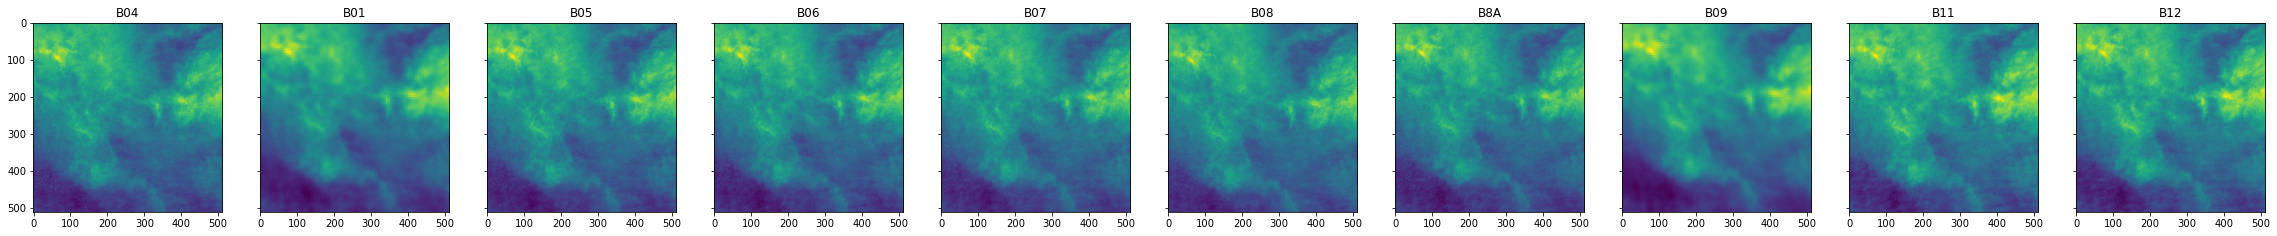

In [62]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def get_array(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return im_arr

chip_id = 'qifc'

file_old = f"../data/train_features/{chip_id}/B04.tif"

im_old = get_array(file_old)
im_old = get_array(file_old)

# bands_new = ['SCL']#, 'AOT']#, 'B01', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12'] 
bands_new = ['B01', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']  
file_new_chip = f"../data/train_features_new/{chip_id}/"


nx = len(bands_new)+1
fig, ax = plt.subplots(1, nx, figsize=(nx*4, 4), sharex=True, sharey=True)

# True color
ax[0].imshow(im_old)
ax[0].set_title("B04")
for iband, band in enumerate(bands_new):
    im_new = get_array(file_new_chip + f"{band}.tif")

    cb = ax[iband+1].imshow(im_new)#, vmin=7,vmax=11, cmap=plt.cm.tab10, interpolation='none')
    ax[iband+1].set_title(band)